In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [2]:
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import rpg_e2vid.utils.inference_utils
import rpg_e2vid.utils.loading_utils
import torch
import tqdm

In [3]:
MODEL_PATH = pathlib.Path("../pretrained/E2VID_lightweight.pth.tar")
DATA_PATH = pathlib.Path("./parsed/")
VIDEOS_PATH = pathlib.Path("./videos/")

data_files = list(DATA_PATH.glob("*.bin"))[:500]

In [4]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [5]:
model = rpg_e2vid.utils.loading_utils.load_model(MODEL_PATH)

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\rpg_e2vid\utils\loading_utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_model = torch.lo

Using TransposedConvLayer (fast, with checkerboard artefacts)


In [6]:
def load_from_file(path: pathlib.Path | str) -> np.ndarray:
    with open(path, "rb") as f:
        events = np.fromfile(f, dtype=np.uint8).reshape(-1, 8)

    meta_entry = events[-1]
    events = events[:-1]

    n_events = meta_entry[4:].view(dtype=np.uint32)[0]
    assert n_events == len(events), f"Expected {n_events} events, got {len(events)}"

    ts_data = np.hstack([events[:, :3], np.zeros((n_events, 1), dtype=np.uint8)]).view(
        dtype=np.uint32
    )
    xs_data = events[:, 3:5].view(dtype=np.uint16).reshape(-1, 1)
    ys_data = events[:, 5:7].view(dtype=np.uint16).reshape(-1, 1)

    events = np.hstack([ts_data, xs_data, ys_data, events[:, 7].reshape(-1, 1)]).astype(
        np.float32
    )
    return events

In [7]:
events = load_from_file(data_files[0])

In [ ]:
e_ts = events[:, 0]
_, counts = np.unique(e_ts, return_counts=True)

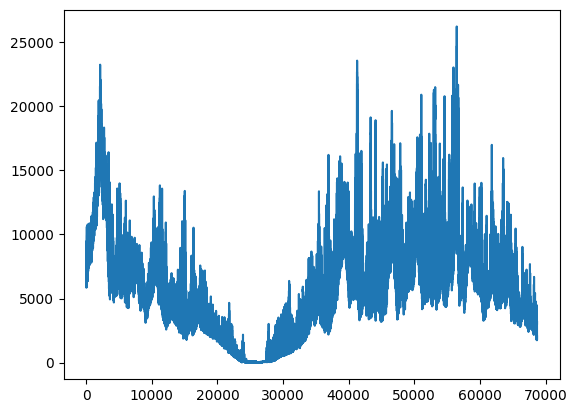

In [ ]:
plt.plot(counts)

In [ ]:
vg = rpg_e2vid.utils.inference_utils.events_to_voxel_grid(
    events[1000:151000], 5, 640, 480
)

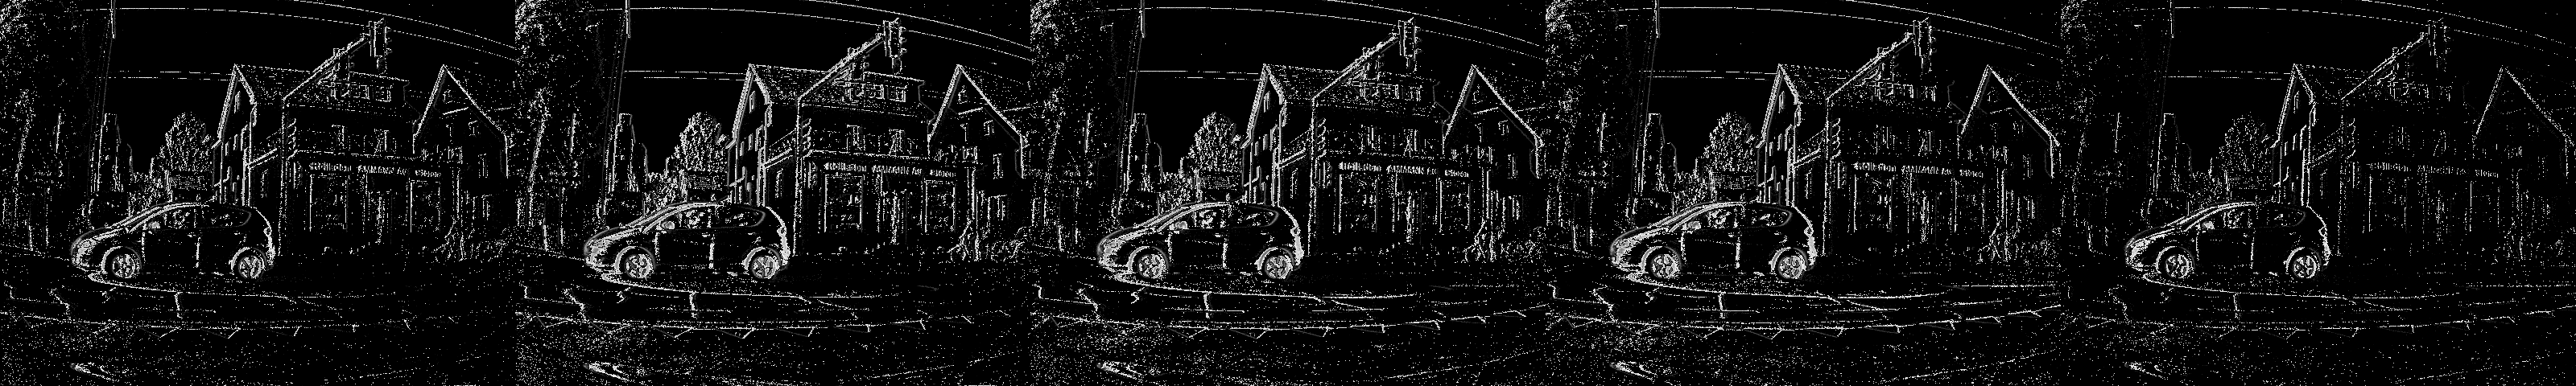

In [ ]:
vgs = np.hstack(vg) / vg.max()
vgs = (vgs * 255).astype(np.uint8)
showarray(vgs)

In [ ]:
timespan = events[-1, 0] - events[0, 0]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WIDTH, HEIGHT = 640, 480
BIN_SIZE = 5
WINDOW_LENGTH_MS = 35
num_windows = int(np.ceil(timespan / WINDOW_LENGTH_MS))
target_fps = 1000 / WINDOW_LENGTH_MS

In [9]:
cap = cv2.VideoCapture(VIDEOS_PATH / "highway1.mp4")
src_frames = []
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for i in tqdm.tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break
    src_frames.append(frame)
src_frames = np.array(src_frames, dtype=np.uint8)
cap.release()

or_height, or_width = src_frames.shape[1:3]
target_height = HEIGHT * 2
target_width = WIDTH * 2

src_frames = src_frames[
    :,
    (or_height - target_height) // 2 + 100 : (or_height + target_height) // 2 + 100,
    (or_width - target_width) // 2 : (or_width + target_width) // 2,
    :,
]

src_frames = np.array([cv2.resize(frame, (WIDTH, HEIGHT)) for frame in src_frames])

100%|██████████| 3383/3383 [00:10<00:00, 325.09it/s]


In [10]:
model = model.to(DEVICE)

### Video Reconstruction

In [11]:
timestamps, counts = np.unique(events[:, 0], return_counts=True)

In [25]:
class EventWindowIterator:
    def __init__(
        self,
        events: np.ndarray,
        counts: np.ndarray,
        window_length: int,
        stride: int = 1,
        offset: int = 0,
    ) -> None:
        self.events = events
        self.counts = counts
        self.event_index = 0
        self.count_index = 0
        self.window_length = window_length
        self.stride = stride
        self.offset = offset

    def __iter__(self):
        return self

    def __next__(self) -> np.ndarray:
        window_start = self.offset + self.count_index

        if window_start >= self.counts.shape[0]:
            raise StopIteration

        window_end = window_start + self.window_length
        total_counts = self.counts[window_start:window_end].sum()
        window = self.events[self.event_index : self.event_index + total_counts]
        stride_counts = self.counts[window_start : window_start + self.stride].sum()
        self.event_index += stride_counts
        self.count_index += self.stride
        return window

    def __len__(self) -> int:
        res, rem = divmod(self.counts.shape[0] - self.offset, self.stride)
        return res + bool(rem)

In [130]:
for ts, c in zip(timestamps[:10], counts):
    print(int(ts), c)

690369 2472
690370 2949
690371 3125
690372 2870
690373 3477
690374 3327
690375 2619
690376 2776
690377 2598
690378 2547


In [32]:
evit = EventWindowIterator(events, counts, 10, stride=10)

for _ in tqdm.tqdm(evit, total=len(evit)):
    ...

100%|██████████| 12133/12133 [00:00<00:00, 92123.35it/s]


In [24]:
time_start = events[0, 0]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(
    VIDEOS_PATH / f"reconstructed-full-{WINDOW_LENGTH_MS}ms.mp4",
    fourcc,
    target_fps,
    (WIDTH, HEIGHT),
)

pbar = tqdm.tqdm(range(num_windows), total=num_windows)
rec_frames = []
prev = None
ts_idx = 0
for i in pbar:
    window_start = WINDOW_LENGTH_MS * i
    window_end = window_start + WINDOW_LENGTH_MS
    total_counts = counts[window_start:window_end].sum()
    window_events = events[ts_idx : ts_idx + total_counts]
    ts_idx += total_counts
    voxel_grid = utils.inference_utils.events_to_voxel_grid(
        window_events, BIN_SIZE, WIDTH, HEIGHT
    )
    voxel_grid = torch.from_numpy(voxel_grid).unsqueeze(0).float().to(DEVICE)
    pbar.set_postfix({"time": f"({window_start:.0f}-{window_end:.0f})"})
    with torch.no_grad():
        pred, prev = model(voxel_grid, prev)

    output = (pred.squeeze().cpu().numpy() * 255).astype(np.uint8)
    rec_frames.append(output)
    # gray to colormap
    output = cv2.applyColorMap(output, cv2.COLORMAP_VIRIDIS)
    cv2.putText(
        output,
        f"{window_start:.0f} ms",
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        1,
    )

    out.write(output)

out.release()


rec_frames = np.array(rec_frames)

100%|██████████| 3467/3467 [03:55<00:00, 14.75it/s, time=(121310-121345)]


### Manual temporal offset search, preliminary results

In [25]:
temporal_offset = 29

In [26]:
out = cv2.VideoWriter(VIDEOS_PATH / "comparison.mp4", fourcc, 10, (WIDTH * 2, HEIGHT))
shifted_rec_frames = rec_frames[temporal_offset:]
for original, reconstructed in tqdm.tqdm(
    zip(src_frames, shifted_rec_frames),
    total=min(len(src_frames), len(shifted_rec_frames)),
):
    reconstructed = cv2.applyColorMap(reconstructed, cv2.COLORMAP_VIRIDIS)
    combined = np.hstack([original, reconstructed])
    out.write(combined)

out.release()

100%|██████████| 3383/3383 [00:15<00:00, 219.26it/s]


In [27]:
out = cv2.VideoWriter(VIDEOS_PATH / "overlayed.mp4", fourcc, 10, (WIDTH, HEIGHT))
shifted_rec_frames = rec_frames[temporal_offset:]
for original, reconstructed in tqdm.tqdm(
    zip(src_frames, shifted_rec_frames),
    total=min(len(src_frames), len(shifted_rec_frames)),
):
    reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_GRAY2BGR)
    original = cv2.resize(original, (WIDTH, HEIGHT))
    overlayed = cv2.addWeighted(original, 0.5, reconstructed, 0.5, 0)
    out.write(overlayed)

out.release()

  0%|          | 0/3383 [00:00<?, ?it/s]

100%|██████████| 3383/3383 [00:06<00:00, 514.54it/s]


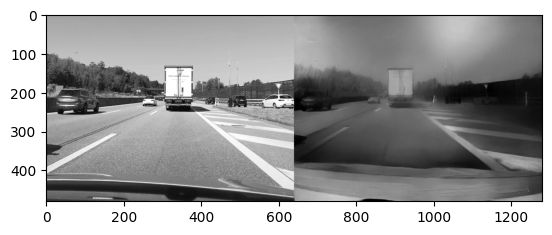

In [28]:
sampled_idx = 300

sampled_original_gs = cv2.cvtColor(src_frames[sampled_idx], cv2.COLOR_BGR2GRAY)
sampled_reconstructed = rec_frames[sampled_idx + temporal_offset]

concat = np.hstack([sampled_original_gs, sampled_reconstructed])
plt.imshow(concat, cmap="gray")

### Spacial Alignment

In [29]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(sampled_original_gs, None)
kp2, des2 = orb.detectAndCompute(sampled_reconstructed, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des2, des1)
matches = sorted(matches, key=lambda x: x.distance)

src_points = np.array([kp2[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_points = np.array([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

In [30]:
sampled_reconstructed_warped = cv2.warpPerspective(
    sampled_reconstructed, M, (WIDTH, HEIGHT)
)

In [41]:
sampled_original_gs_warped = cv2.warpPerspective(
    sampled_original_gs, M, (WIDTH, HEIGHT)
)

In [37]:
M

array([[ 1.10537273e+00, -1.71082704e-01,  5.68381444e+01],
       [ 4.69460981e-02,  9.64188534e-01, -1.22149388e+01],
       [ 1.47398028e-04, -4.38757896e-04,  1.00000000e+00]])

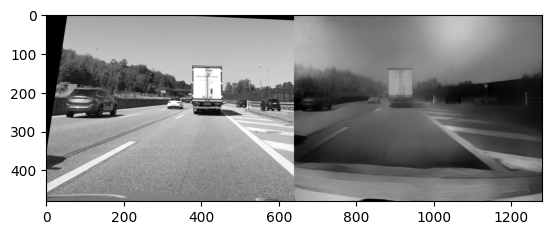

In [42]:
plt.imshow(np.hstack([sampled_original_gs_warped, sampled_reconstructed]), cmap="gray")

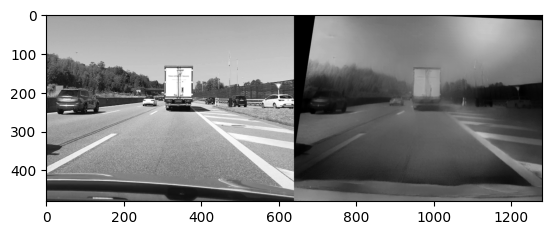

In [43]:
plt.imshow(np.hstack([sampled_original_gs, sampled_reconstructed_warped]), cmap="gray")

In [44]:
out = cv2.VideoWriter(VIDEOS_PATH / "overlayed-warped.mp4", fourcc, 10, (WIDTH, HEIGHT))
shifted_rec_frames = rec_frames[temporal_offset:]
for original, reconstructed in tqdm.tqdm(
    zip(src_frames, shifted_rec_frames),
    total=min(len(src_frames), len(shifted_rec_frames)),
):
    reconstructed = cv2.warpPerspective(reconstructed, M, (WIDTH, HEIGHT))
    invalid_mask = reconstructed == 0
    reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_GRAY2BGR)
    original = cv2.resize(original, (WIDTH, HEIGHT))
    overlayed = cv2.addWeighted(original, 0.5, reconstructed, 0.5, 0)
    final = np.zeros_like(overlayed)
    final[invalid_mask] = original[invalid_mask]
    final[~invalid_mask] = overlayed[~invalid_mask]
    out.write(final)

out.release()

100%|██████████| 3383/3383 [00:52<00:00, 63.98it/s]


In [21]:
out = cv2.VideoWriter(VIDEOS_PATH / "filled-in-warped.mp4", fourcc, 10, (WIDTH, HEIGHT))
shifted_rec_frames = rec_frames[temporal_offset:]
for original, reconstructed in tqdm.tqdm(
    zip(src_frames, shifted_rec_frames),
    total=min(len(src_frames), len(shifted_rec_frames)),
):
    reconstructed = cv2.warpPerspective(reconstructed, M, (WIDTH, HEIGHT))
    invalid_mask = reconstructed == 0
    reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_GRAY2BGR)
    original = cv2.resize(original, (WIDTH, HEIGHT))

    final = np.zeros_like(reconstructed)
    final[invalid_mask] = original[invalid_mask]
    final[~invalid_mask] = reconstructed[~invalid_mask]

    out.write(final)

out.release()

100%|██████████| 472/472 [00:07<00:00, 62.76it/s]


### Temporal alignment

**Tested approaches:**
1. maximizing TP on warped first canny frame edges and voxelized events:
    - window 1ms [ X ]
    - window 25ms [ X ]
    - window 10ms [ X ]
    - window with 50ms [ X ]
    - window 25ms, exclude the middle section of a the frame from the consideration [ X ]
1. minimizing FP on warped first canny frame edges and voxelized events:
    - window 50ms, exclude the left/right sections of a the frame from the consideration [ ✓ ] - pretty good selection of the matching timestamp
    - same as above - but consider only positive polarity [ X ]
    - same as above - but consider only negative polarity [ X ]
    - window 50ms, exclude the left/right sections of a the frame from the consideration, 2xdilation on canny [ ✓ ] - pretty good selection of the matching timestamp
    - same as above, no dilation [ ✓ ] - pretty good but seems more fragile
    - window 50ms, exclude the left/right sections of a the frame from the consideration, no erosion on event frame []
1. edges with hough lines [ X ]
1. ORB between unwarped first canny frame and voxelized event from 1ms [ X ]

In [22]:
## inverse homography
M_inv = np.linalg.inv(M)
# hey, copilot
# give me a unicode tick
# thanks
# ✓

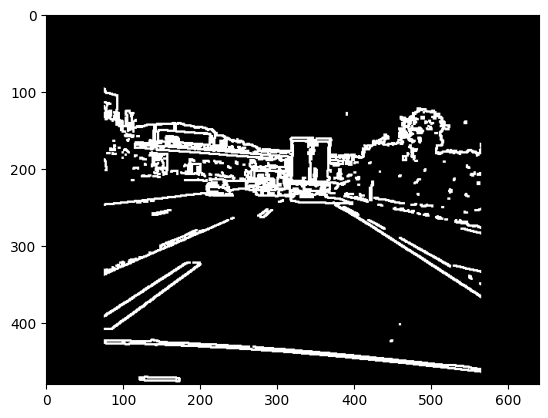

In [272]:
first_src_frame = src_frames[0]
first_src_frame_canny = cv2.Canny(first_src_frame, 300, 400)
first_src_frame_canny = np.where(first_src_frame_canny > 0, 255, 0).astype(np.uint8)
first_src_frame_canny = cv2.dilate(
    first_src_frame_canny, kernel=np.ones((3, 3), np.uint8), iterations=1
)
first_src_frame_canny[:, :75] = 0
first_src_frame_canny[:, 640 - 75 :] = 0
# first_src_frame_canny = cv2.warpPerspective(
#     first_src_frame_canny, M_inv, (WIDTH, HEIGHT)
# )
plt.imshow(first_src_frame_canny, cmap="gray")
plt.show()

In [389]:
out = cv2.VideoWriter(
    VIDEOS_PATH / "raw_events.mp4", fourcc, 30, (WIDTH, HEIGHT), isColor=True
)
window_len = 50
ts_idx = 0
proc_event_frames = []
raw_event_frames = []
tps = []
fns = []
fps = []
kernel = np.array([[0, 0, 0], [0, 0, 1], [0, 0, 1]], np.uint8)
for i in tqdm.tqdm(iterable=range(min(5000, int(timespan)))):
    num_events = counts[i : i + window_len].sum()
    events_in_window = events[ts_idx : ts_idx + num_events].astype(np.int32)
    ts_idx += counts[i]
    frame = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    frame[events_in_window[:, 2], events_in_window[:, 1]] = 255
    frame = cv2.erode(frame, kernel, iterations=1)
    # find matches between the frame and tha canny edge
    frame = cv2.warpPerspective(frame, M, (WIDTH, HEIGHT))
    raw_event_frames.append(frame)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    tp_mask = (first_src_frame_canny > 0) & (frame > 0)
    fn_mask = (first_src_frame_canny > 0) & (frame == 0)
    fp_mask = (first_src_frame_canny == 0) & (frame > 0)
    fp_mask[:, :75] = 0
    fp_mask[:, 640 - 75 :] = 0
    tps.append(tp_mask.sum())
    fns.append(fn_mask.sum())
    fps.append(fp_mask.sum())
    frame_bgr[fn_mask] = [0, 0, 255]
    frame_bgr[tp_mask] = [0, 255, 0]
    proc_event_frames.append(frame_bgr)
    cv2.putText(
        frame_bgr,
        f"{i:>8.0f} ms",
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
    )

    out.write(frame_bgr)
out.release()
proc_event_frames = np.array(proc_event_frames)
raw_event_frames = np.array(raw_event_frames)
tps = np.array(tps)
fns = np.array(fns)
fps = np.array(fps)

100%|██████████| 5000/5000 [00:39<00:00, 128.18it/s]


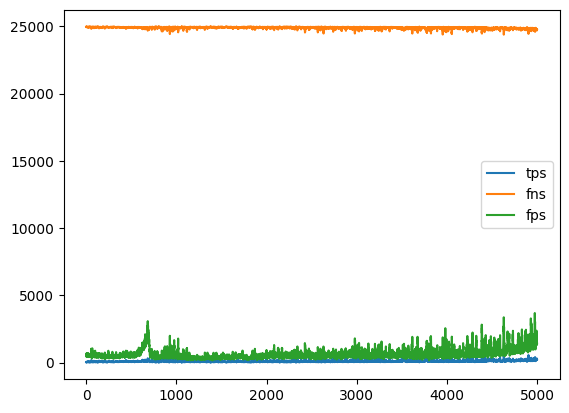

In [388]:
plt.plot(tps, label="tps")
plt.plot(fns, label="fns")
plt.plot(fps, label="fps")
plt.legend()

In [324]:
np.argmax(tps), np.max(tps)

(4588, 12899)

In [325]:
np.argmin(fps), np.min(fps)

(1161, 29683)

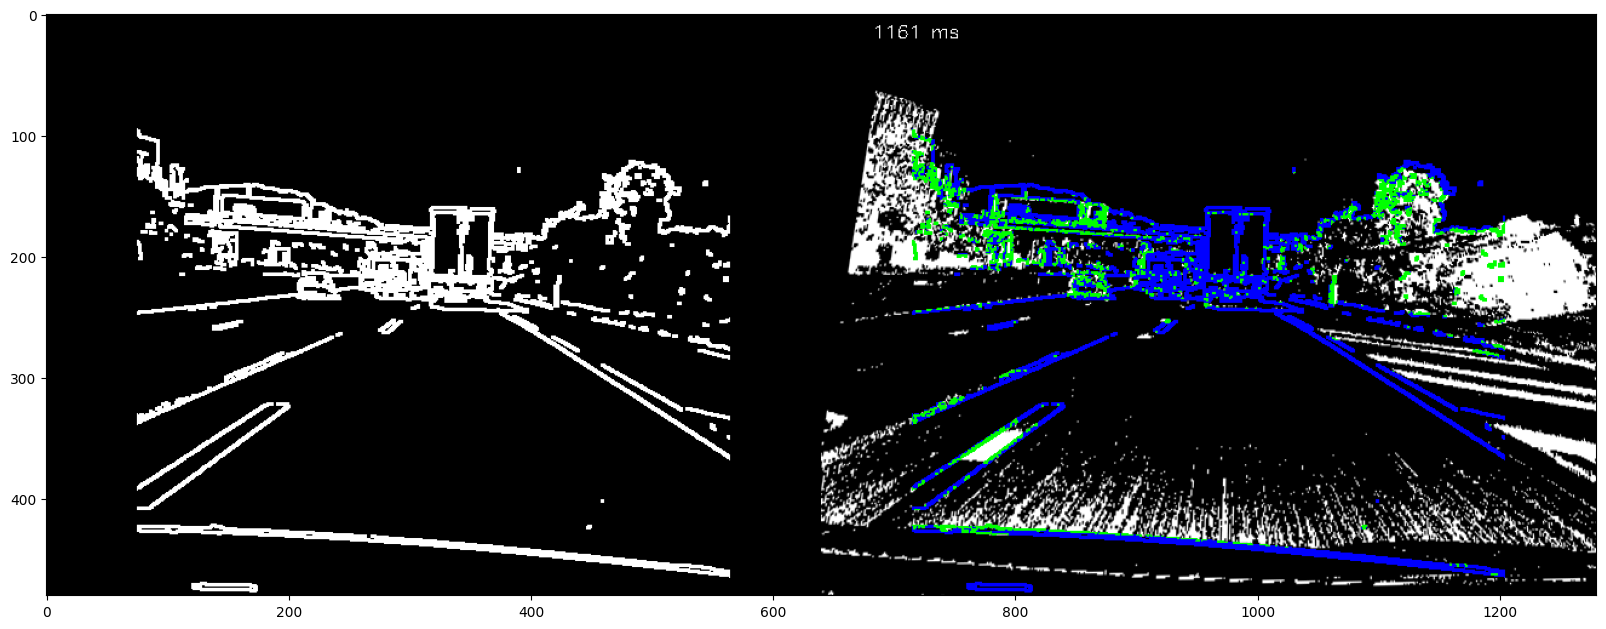

In [326]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
first_src_frame_canny_bgr = cv2.cvtColor(first_src_frame_canny, cv2.COLOR_GRAY2BGR)
ax.imshow(
    np.hstack([first_src_frame_canny_bgr, proc_event_frames[np.argmin(fps)]]),
    cmap="gray",
)

In [340]:
counts.shape

(17523,)

In [386]:
new_event_agg_frames = []
new_offset = np.argmin(fps)
ts_start = new_offset
ts_idx = counts[:ts_start].sum()
for i in range((len(counts) - new_offset) // WINDOW_LENGTH_MS):
    window_start = new_offset + i * WINDOW_LENGTH_MS
    window_end = window_start + WINDOW_LENGTH_MS
    total_counts = counts[window_start:window_end].sum()
    events_in_window = events[ts_idx : ts_idx + total_counts].astype(np.int32)
    ts_idx += total_counts
    frame = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    frame[events_in_window[:, 2], events_in_window[:, 1]] = 255
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    new_event_agg_frames.append(frame)

new_event_agg_frames = np.array(new_event_agg_frames)

out = cv2.VideoWriter(
    VIDEOS_PATH / "overlayed-warped-new-offset.mp4", fourcc, 10, (WIDTH, HEIGHT)
)
for original, reconstructed in tqdm.tqdm(
    zip(src_frames, new_event_agg_frames),
    total=min(len(src_frames), len(new_event_agg_frames)),
):
    reconstructed = cv2.warpPerspective(reconstructed, M, (WIDTH, HEIGHT))
    original = cv2.resize(original, (WIDTH, HEIGHT))
    overlayed = cv2.addWeighted(original, 0.5, reconstructed, 0.5, 0)
    out.write(overlayed)

out.release()

100%|██████████| 467/467 [00:01<00:00, 350.91it/s]


In [399]:
out = cv2.VideoWriter(
    VIDEOS_PATH / "overlayed-warped-gs-diff.mp4", fourcc, 10, (WIDTH, HEIGHT)
)

shifted_rec_frames = rec_frames[temporal_offset:]

for original, reconstructed in tqdm.tqdm(
    zip(src_frames, shifted_rec_frames),
    total=min(len(src_frames), len(shifted_rec_frames)),
):

    reconstructed = cv2.warpPerspective(reconstructed, M, (WIDTH, HEIGHT))

    invalid_mask = reconstructed == 0

    original = cv2.resize(original, (WIDTH, HEIGHT))

    original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    diff = cv2.absdiff(original, reconstructed)

    diff[invalid_mask] = 0

    diff[diff < 128] = 0

    diff = cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)

    out.write(diff)

out.release()

100%|██████████| 472/472 [00:01<00:00, 376.34it/s]


In [397]:
diff

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[82, 82, 82],
        [86, 86, 86],
        [86, 86, 86],
        ...,
        [75, 75, 75],
        [74, 74, 74],
        [74, 74, 74]],

       [[89, 89, 89],
        [88, 88, 88],
        [84, 84, 84],
        ...,
        [77, 77, 77],
        [77, 77, 77],
        [77, 77, 77]],

       [[93, 93, 93],
        [92, 92, 92],
        [91, 91, 91],
        ...,
        [79, 79, 79],
        [78, 78, 78],
        [78, 78, 78]]], dtype=uint8)